In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from itertools import permutations, combinations

from datasets import Data_From_File
from sklearn.metrics import ndcg_score
from perms import Gk

import matplotlib.pyplot as plt


In [13]:
class Data_for_torch(Dataset, Data_From_File):
    
    def __init__(self, file, which = 0):
        
        self.data = pd.DataFrame(Data_From_File.open_file(file)[which]).drop('doc_id', axis = 1)
        self.dict_data = self.data.set_index('query_id').T.to_dict('list')
        self.keys = list(self.dict_data.keys())
        
    def __len__(self):
        return len(self.dict_data)
        
    def __getitem__(self, idx):
        key = self.keys[idx]
        return self.dict_data[key]

In [14]:
train_data = Data_for_torch('datas_full_10k_1.pkl', which = 0)
vali_data = Data_for_torch('datas_full_10k_1.pkl', which = -1)

In [15]:
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(vali_data, batch_size=1)

In [16]:
class ListNet(nn.Module):
    def __init__(self,inp_size = 136, out_size = 1 ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inp_size, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,out_size),
            
            )
        
        # self.razdel = torch.tensor(['_' for i in range(inp_size)])
        
    def forward(self, X):
        output = self.model(X).squeeze()
        return output
    # dict_y = {}

In [17]:
def loss(p,y):
    return -torch.mean(y * torch.log_softmax(p, dim = -1))

def vali(vali_loader, model, k = [5,10,None]):
    model.eval()
    
    device = next(model.parameters()).device
    acc = np.zeros(3)
    length = len(vali_loader)
    
    for batch in vali_loader:
        X = batch[0].to(device)
        y = batch[1].cpu().view(-1).numpy()
            
        preds = model(X.float()).view(-1).detach().cpu().numpy()
        for j,i in enumerate(k):
            try:
                acc[j] += ndcg_score([list(y)], [list(preds)], k = i)
            except:
                length -= 1

            
    return acc / length

def train(train_dataloader, test_dataloader, model, loss_fn, optimizer, sheluder, epochs, is_test = True, is_sheluder = False ):
    device = next(model.parameters()).device
    
    pred_probs = nn.Softmax(dim = -1)
    y_probs = nn.Softmax(dim = -1)
    
    train_loss = []
    metric = []
    
    
    
    for i in range(epochs):
        loss_epoch = 0
        
        model.train()
        for batch in train_dataloader:
            X = batch[0].float().to(device)
            y = batch[1].squeeze().float().to(device)
            
            preds = model(X).squeeze()
            
            probas_p = preds
            probas_y = y
            
            optimizer.zero_grad()            
            loss_ = loss_fn(probas_p, probas_y)
            loss_.backward()
            optimizer.step()

            loss_epoch += loss_
          
        
        train_loss.append(loss_epoch.clone().detach().cpu().numpy()/len(train_dataloader))
        
        if is_test:
            model.eval()
            metric.append(vali(vali_loader=test_dataloader, model = model))
            print(f'loss for epoch {i+1} is {train_loss[i]:.4f} ||for epoch{i+1} ndcg@5_score is {metric[i][0]:.4f} || ndcg@10_score is {metric[i][1]:.4f} || ndcg_score is {metric[i][2]:.4f}  ')
        else:    
            print(f'loss for epoch {i+1} is {train_loss[i]:.4f}')
            
        if is_sheluder:   
            sheluder.step(loss_epoch)
            
    return np.array(train_loss), np.array(metric)
    
        
def plot_loss_and_metric(train_loss, name, is_metric = True, metric = []):
    size = len(train_loss)
    
    if is_metric:
        fig, ax = plt.subplots(1,4, figsize = (20,6), constrained_layout=True)
        
        
        ax[0].set_yscale('log')
        ax[0].plot(np.arange(size), train_loss)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('loss')
        ax[0].set_title('train loss')
        ax[0].grid(True)
        
        for i,j  in enumerate([5,10,'']):
        
            ax[i+1].plot(np.arange(size), metric[:,i])
            ax[i+1].set_xlabel('epochs')
            ax[i+1].set_ylabel(f'ndcg@{j}_score')
            ax[i+1].set_title('eval metric')
            ax[i+1].grid(True)

        
        fig.savefig(name)
        plt.show()
        
    else:
        fig, ax = plt.subplots(figsize = (6,6))
        fig.set_figheight(8)
        fig.set_figwidth(12)
        
        ax.set_yscale('log')
        ax.plot(np.arange(size), train_loss)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        ax.set_title('train loss')
        ax.grid(True)
                
        fig.savefig(name)

        plt.show()
        
            

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ListNet().to(device)

kl_loss = nn.KLDivLoss()

opt_adam = torch.optim.AdamW(model.parameters(), lr=0.0001)

m_loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, mode='min', patience=3, factor=0.1, verbose=True)

/home/aletovv/anaconda3/envs/v-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


Number of trainable parameters: 164801


'cuda'

In [20]:
losses = train(train_dataloader=train_loader,
               test_dataloader= test_loader,
      model = model,
      loss_fn=loss,
      optimizer=opt_adam,sheluder=scheduler,
      epochs=150)

loss for epoch 1 is 46.0621 ||for epoch1 ndcg@5_score is 0.2907 || ndcg@10_score is 0.3143 || ndcg_score is 0.6557  
loss for epoch 2 is 8.8888 ||for epoch2 ndcg@5_score is 0.3084 || ndcg@10_score is 0.3444 || ndcg_score is 0.6731  
loss for epoch 3 is 9.1643 ||for epoch3 ndcg@5_score is 0.3572 || ndcg@10_score is 0.3790 || ndcg_score is 0.6881  
loss for epoch 4 is 10.1568 ||for epoch4 ndcg@5_score is 0.4268 || ndcg@10_score is 0.4378 || ndcg_score is 0.7142  
loss for epoch 5 is 6.6985 ||for epoch5 ndcg@5_score is 0.4231 || ndcg@10_score is 0.4368 || ndcg_score is 0.7153  
loss for epoch 6 is 6.7772 ||for epoch6 ndcg@5_score is 0.3941 || ndcg@10_score is 0.4176 || ndcg_score is 0.7068  
loss for epoch 7 is 6.5715 ||for epoch7 ndcg@5_score is 0.4484 || ndcg@10_score is 0.4587 || ndcg_score is 0.7249  
loss for epoch 8 is 30.4636 ||for epoch8 ndcg@5_score is 0.4429 || ndcg@10_score is 0.4526 || ndcg_score is 0.7224  
loss for epoch 9 is 5.0597 ||for epoch9 ndcg@5_score is 0.4132 || ndc

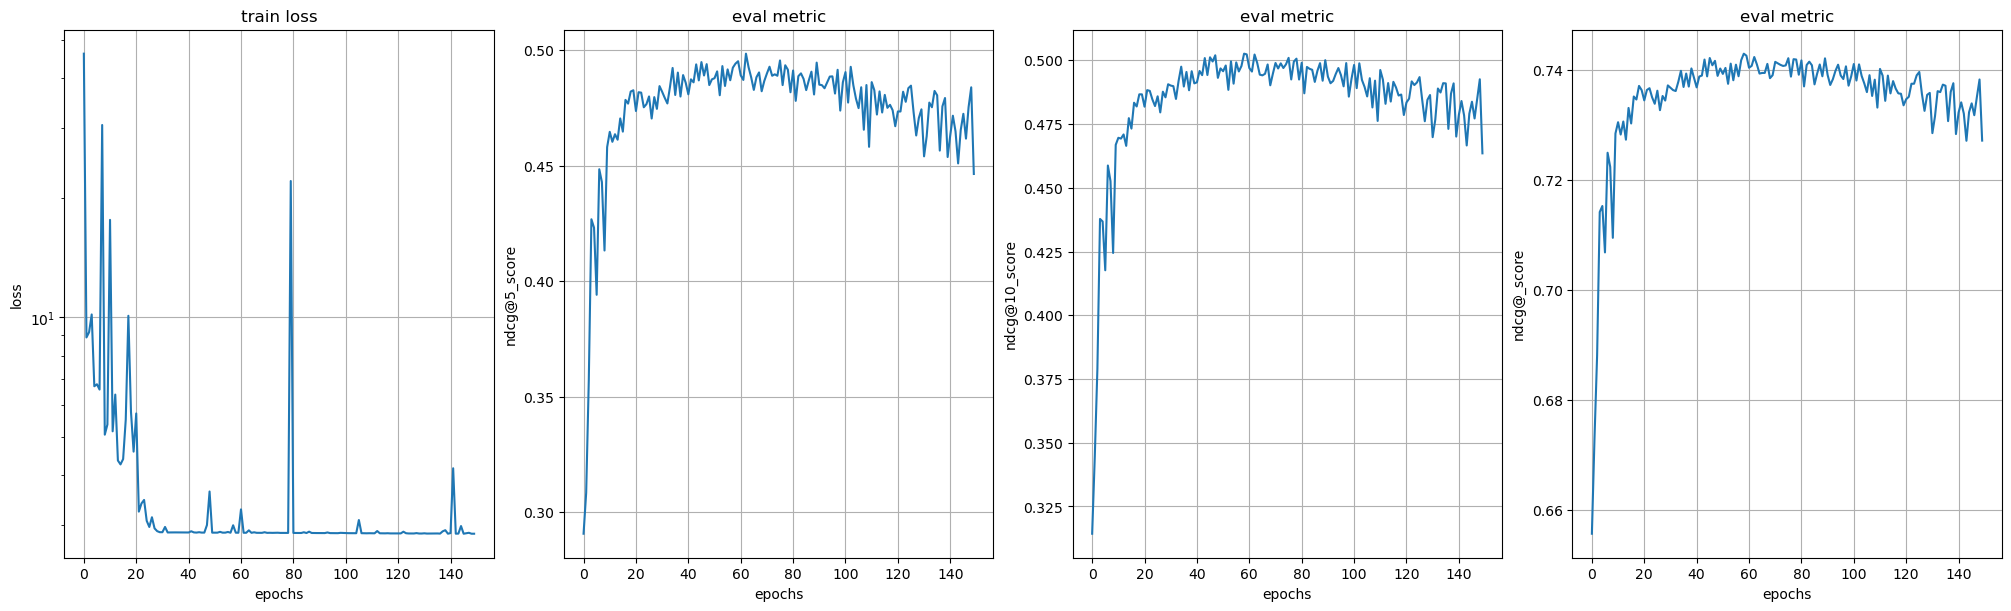

In [21]:
plot_loss_and_metric(train_loss=losses[0], metric = losses[1],  name = 'loss and metric for lin_model_1_crosentr_from_tabnet')



In [22]:
name = 'lin_model_1_crosentr_from_tabnet '
torch.save(model, name)